https://github.com/farizrahman4u/seq2seq

1. Seq2Seq(sequence-to-sequence)이란? :

  - Seq2Seq의 구조 :
  
  a.seq2seq 시퀀스를 받고 다른 시퀀스로 변환하는 모델로, 문장 등의 입력을 압축하는 encoder와 출력을 전개하는 decoder로 구성
  
  b.encoder와 decoder에 각각 RNN 층이 구축되어 encoder와 decoder가 연결시킴으로써 seq2seq가 만들어 진다.
  
  c. "나는 펜을 가지고 있다"라는 문장을 "I have a pen "라는 영문으로 번역하는 것이 가능하다
     "대화문장 응답"
     
     - Encoder : 각시간마다 시계열 데이터(문장)으로 입력된다.
                 -> RNN(LSTM)입력된 시퀀스를 처리한다. -> RNN의 출력결과 -> 시퀀스 결과를 가진다.
                 
     - Decoder : 문장이 순서대로 주어지면 대상 시퀀스의 다음문자를 예측하도록 훈련된다.
                 -> RNN의 출력결과는 무시하고 다음 문자를 예측한다.
                 
     - 추론 단계 : 입력단어(시퀀스 : 영문) -> 벡터변환 -> LSTM층을 이용해서 Encoder가 된다.
       -> 입력데이터를 내부상태로 변환 과정을 가진다(1문장의 대상시퀀스를 Decoder에 입력하고) ->
       다음 문장의 변환 과정을 가진다. -> 다음문장을 한글로 선택하는 샘플링 작업 -> 샘플링한 단어를 정답
       -> 시퀀스의 종류문자가 생성될때 까지 반복
       
2. LSTM 연동
   - Encoder : LSTM 층을 이용해서 영문시퀀스를 입력하게 되면 2개의 값을 출력한다.
   - Decoder : states_내부상태값을 초기상태로 지정해서 사용하게 된다.
   
 Encoder
   encoder_input  ->  LSTM(encoder_lstm)  ->  (encoder_output, state_h, state_c)  ->  state
                      return sequences = False
                      return state = True
 
 Decoder
   state -> LSTM(dncoder_lstm) -> (decoder_output, state_h, state_c) -> dense -> decoder-output
            return sequences = False
            return state = True
            
      -> translated

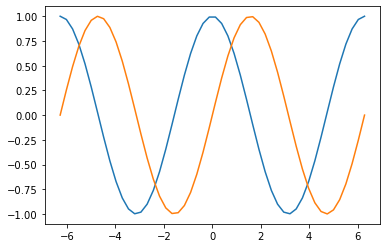

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#훈련용 데이터 생성
#cos함수값은 encoder, sin 함수값은 decoder에 입력
x_ax = np.linspace(-2 * np.pi, 2 * np.pi) # -2π에서 2π까지의 50개의 값
cos_data = np.cos(x_ax)
sin_data = np.sin(x_ax)

plt.plot(x_ax, cos_data)
plt.plot(x_ax, sin_data)
plt.show()

In [5]:
#02. 인코더와 디코더의 모양을 만들자
#시계열 수를 10을 지정

n_rnn = 10  #시계열 수
n_sample = len(x_ax) - n_rnn #샘플

x_encoder = np.zeros((n_sample,n_rnn))  #encoder의 입력
x_decoder = np.zeros((n_sample,n_rnn))  #decoder의 입력
t_decoder = np.zeros((n_sample,n_rnn))  #decoder의 출력

print(x_encoder.shape)
print(x_decoder.shape)
print(t_decoder.shape)

#03. x_encoder에 cos 함수값을 지정하고 x_decoder에 sin 값을 지정한다.
for i in range(0, n_sample) :
    x_encoder [i] = cos_data[i:i+n_rnn]
    x_decoder[i,1:] = sin_data[i: i+n_rnn - 1]
    
#04. t_decoder에 sin 값을 그대로 대입
for j in range(0, n_sample):
    t_decoder[j] = sin_data[j:j+n_rnn]
    
#05. 뉴런 데이터 형으로 변환
x_encoder = x_encoder.reshape(n_sample,n_rnn,1)
x_decoder = x_decoder.reshape(n_sample,n_rnn,1)
t_decoder = t_decoder.reshape(n_sample,n_rnn,1)


(40, 10)
(40, 10)
(40, 10)


step 2] Seq2Seq 구축(학습 모델 구축, 예측모델 구축)

1. 학습모델 구축 (모델설정) : Model 해당 클래스만 사용 LSTM
2. 학습모델 구축 (encoder의 구축)
3. 학습모델 구축 (decoder의 구축)
4. 학습모델 구축 (모델 컴파일)
5. 학습모델 구축 (학습모델 구축한 것을 학습실시)
6. 학습모델 구축 (학습 값을 확인한다.)

7. 예측모델 구축(encoder 구축)
8. 예측모델 구축(decoder 구축)

9. 번역에 대한 함수를 정의

In [12]:
#step 2] Seq2Seq 구축(학습 모델 구축, 예측모델 구축)
#1. 학습모델 구축(모델선정) : Model 해당 클래스만 사용 LSTM

from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1  # 입력 층의 뉴런 수
n_mid = 20  # 중간층 뉴런 수
n_out = n_in  #출력층 뉴런 수

encoder_input = Input(shape = (n_rnn, n_in))  #시계열 수, 입력층 수

encoder_lstm = LSTM(n_mid, return_state = True)
#중간층 (return_state = True : 해당시간 출력 ht, 상태를 리턴)

#2. 학습 모델 구축(encoder의 구축)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h,encoder_state_c]

In [13]:
#3 학습모델 구축(decoder의 구축)
decoder_input = Input(shape = (n_rnn, n_in))  #디코더 입력 레이어
decoder_lstm = LSTM(n_mid, return_sequences = True, return_state = True)

#decoder에서 출력한 상태는 전혀 사용하지 않는다.
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state = encoder_state)

decoder_dense = Dense(n_out, activation = 'linear')  #결합층
decoder_output = decoder_dense(decoder_output)

In [14]:
#4. 모델 구축(모델 컴파일)
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss = "mean_squared_error", optimizer = "sgd")
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 20), (None,  1760        input_6[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 10, 20), (No 1760        input_7[0][0]                    
                                                                 lstm_5[0][1]               

In [15]:
#5. 학습모델 구축(학습모델 구축한 것을 학습을 실시)
history = model.fit([x_encoder, x_decoder],t_decoder, batch_size = 8, epochs = 30)

Epoch 1/30
5/5 [==============================] - 4s 5ms/step - loss: 0.6734
Epoch 2/30
5/5 [==============================] - 0s 5ms/step - loss: 0.6241
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 0.5940
Epoch 4/30
5/5 [==============================] - 0s 5ms/step - loss: 0.5420
Epoch 5/30
5/5 [==============================] - 0s 4ms/step - loss: 0.5203
Epoch 6/30
5/5 [==============================] - 0s 4ms/step - loss: 0.4824
Epoch 7/30
5/5 [==============================] - 0s 5ms/step - loss: 0.4638
Epoch 8/30
5/5 [==============================] - 0s 4ms/step - loss: 0.4390
Epoch 9/30
5/5 [==============================] - 0s 4ms/step - loss: 0.4153
Epoch 10/30
5/5 [==============================] - 0s 4ms/step - loss: 0.4029
Epoch 11/30
5/5 [==============================] - 0s 4ms/step - loss: 0.3740
Epoch 12/30
5/5 [==============================] - 0s 4ms/step - loss: 0.3669
Epoch 13/30
5/5 [==============================] - 0s 4ms/step - loss: 0.

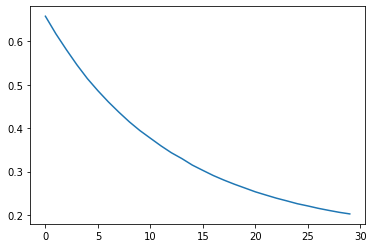

In [16]:
# 6. 학습모델 구축 (학습 값을 확인한다.)
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

In [17]:
#7. 예측모델 구축(encoder 구축)
# encoder는 수신상태로 리턴하고 decoder는 입력과 상태값을 받아서 출력상태를 리턴
# encoder_input - encoder_lstm - encoder_state
encoder_model = Model(encoder_input, encoder_state)

#8. 예측모델 구축(decoder 구축)
decoder_input = Input(shape = (1,n_in))
decoder_state_in_h = Input(shape = (n_mid,))
decoder_state_in_c = Input(shape = (n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]
decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input, initial_state = decoder_state_in)

decoder_state = [decoder_state_h, decoder_state_c]
decoder_output = decoder_dense(decoder_output)
#각각 리스트 값을 유지하고 있으면, 입력으로 전달할 때 각 목록을 결합해서 전달한다 +를 쓴다.
decode_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state)

In [28]:
#9. 번역에 대한 함수를 정의 : 코사인함수 번역해서 사인함수 변환 함수
#encoder 입력값을 예측 모델에 적용하는 함수
def translate(input_data):
    translated = []
    #LSTM 예측, 출력은 내부상태, h,c 2가지가 리턴
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1,1,1))
    
    for i in range(0,n_rnn):
        #시간상태h, 목록c -> decoder_model 학습된 LSTM과 Dense 에 대한 예측
        y,h,c = decode_model.predict([y_decoder] + state_value)
        y = y[0][0][0]  #출력값 y에서 번역된 값을 출력
        translated.append(y)
        y_decoder[0][0][0] = y  #다음 시간에 전달 할 값
        state_value = [h,c]  #다음 시간에 전달할 상태
        
    return translated

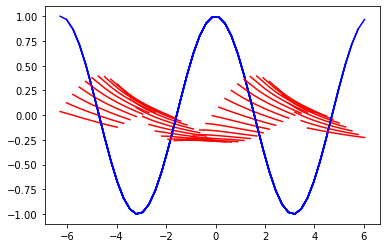

In [29]:
#10 시각화
idices = range(0,40)
for indice in idices :
    x = x_encoder[indice:indice+1]
    y = translate(x)
    
    plt.plot(x_ax[indice:indice+n_rnn], x.reshape(-1), color = "b")
    plt.plot(x_ax[indice:indice+n_rnn], y, color = "r")
    
plt.show()

In [14]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/kor-eng.zip'
filename = 'kor-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)
with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)
    
#%%    
lines= pd.read_csv('kor.txt', names=['src', 'tar', 'cc'], sep='\t')
print( len(lines) )
#%%
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
print( lines )
#%%
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
print(lines.sample(10))
#%%
# 글자 집합 구축
src_vocab=set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)
tar_vocab=set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)
        
print(src_vocab)   
#%%
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)     
#%%
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])
#%%
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)
#%%
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
    
print(encoder_input[:5])
#%%
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
      temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])
#%%
decoder_target = []
for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(tar_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])
#%%
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)
#%%
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')
print(encoder_input)
#%%
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
#%%
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np
#%%
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.
#%%
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
#%%
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=1, validation_split=0.2)
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.
    stop_condition = False
    decoded_sentence = ""
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char
        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.
        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
    return decoded_sentence
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력


3648
                                                    src  \
0                                                   Go.   
1                                                   Hi.   
2                                                  Run!   
3                                                  Run.   
4                                                  Who?   
...                                                 ...   
3643  Science fiction has undoubtedly been the inspi...   
3644  I started a new blog. I'll do my best not to b...   
3645  I think it's a shame that some foreign languag...   
3646  If someone who doesn't know your background sa...   
3647  Doubtless there exists in this world precisely...   

                                                    tar  
0                                                    가.  
1                                                   안녕.  
2                                                   뛰어!  
3                                                   뛰어

HOG - Histogram of Oriented Gradients
: 영상의 지역적 그래디언트 방향 정보를 히스토그램으로 표현해서 영상의 형태를 표현하는 방법
foundLocations(검출된 사각형 영역 정보), foundWeights(검출된 사각형영역가중치) =cv2.HOGDescriptor.detectMultiScale( img, 입력 영상 hitThreshold=None, 특징 벡터와 SVM 분류 평면까지의 거리에 대한 임계값 winStride=None, 셀 윈도우 이동 크기 padding=None, 패딩 크기 scale=None, 검색 윈도우 크기 확대 비율 finalThreshold=None, 검출 결정을 위한 임계값 useMeanshiftGrouping=None 겹쳐진 검색 윈도우를 합치는 플래그 ) -> foundLocations, foundWeights
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 
hogParams = {'hitThreshold' : 0.0,'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05,'finalThreshold':2,'useMeanshiftGrouping':False}

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('c:\\test\\people.mp4')

#프레임의 가로 세로 값 리턴 받기
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
writer = cv2.VideoWriter('c:\\test\\people_res.mp4', fourcc,fps,(width, height))

hog = cv2.HOGDescriptor((48,96),(16,16),(8,8),(8,8),9) #대상을 인식하는 객체
#hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hog.setSVMDetector(cv2.HOGDescriptor_getDaimlerPeopleDetector())
hogParams = {'hitThreshold' : 0.0, 'winStride': (8,8), 'padding' : (32,32), 'scale' : 1.05, 'finalThreshold': 2, 'useMeanshiftGrouping' : True }

while(1):
    ret, frame = cap.read()
    if frame is None:
        break
    h,r = hog.detectMultiScale(frame, **hogParams)
    
    for (x,y,w,h) in h:
        cv2.rectangle(frame,(x,y),(x+w,y+h), (0,50,255),3)
        
    cv2.imshow('frame', frame)
    writer.write(frame)
    
    key = cv2.waitKey(30)
    if key == 27 :
        break
        
cap.release()
writer.release()
cv2.destoryAllWindows()

AttributeError: module 'cv2.cv2' has no attribute 'destoryAllWindows'

In [2]:
import numpy as np
import cv2

img = cv2.imread("c:\\test\\input.jpg")

hog = cv2.HOGDescriptor()
#hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8,8), 'padding' : (32,32), 'scale' : 1.05}

h,r = hog.detectMultiScale(img, **hogParams)
    
for (x,y,w,h) in h:
    cv2.rectangle(img,(x,y),(x+w,y+h), (0,255,0),2)

cv2.imwrite('c:\\test\\res_input.jpg',img)

True

In [9]:
import numpy as np
import cv2 as cv 

# 얼굴과 눈을 검출하기 위해 미리 학습시켜 놓은 XML 포맷으로 저장된 분류기를 로드합니다. 

glasses_cascade = cv.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml') 
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml') 
img = cv.imread('C:\\test\\1.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 

# 이미지에서 얼굴을 검출합니다. 
faces = face_cascade.detectMultiScale(gray, minSize = 1.3, maxSize = 5) 

# 얼굴이 검출되었다면 얼굴 위치에 대한 좌표 정보를 리턴받습니다. 
for (x,y,w,h) in faces:
    # 원본 이미지에 얼굴의 위치를 표시합니다. 
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # 눈 검출은 얼굴이 검출된 영역 내부에서만 진행하기 위해 ROI를 생성합니다. 
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

    # 눈을 검출합니다. 
    eyeglasses = glasses_cascade.detectMultiScale(roi_gray)

    # 눈이 검출되었다면 눈 위치에 대한 좌표 정보를 리턴받습니다. 
    for (ex,ey,ew,eh) in eyes: 

        # 원본 이미지에 얼굴의 위치를 표시합니다. ROI에 표시하면 원본 이미지에도 표시됩니다.
        cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


# 얼굴과 눈 검출 결과를 화면에 보여줍니다.
cv.imshow('img',img)
cv.waitKey(0)
cv.destroyAllWindows()

SystemError: new style getargs format but argument is not a tuple